# Setup

In [1]:
import numpy as np
import pandas as pd
import torch
torch.cuda.empty_cache()

from sklearn.model_selection import train_test_split
from datasets import load_dataset, load_metric, list_metrics
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, DataCollator, T5ForConditionalGeneration, T5TokenizerFast

from tqdm import tqdm

from typing import Dict, List, Optional

import dataclasses
from dataclasses import dataclass, field

import logging
import os
import sys

from huggingface_hub import notebook_login

import datasets
from datasets import Dataset

from transformers import(
    T5ForConditionalGeneration, 
    RobertaTokenizer,
    T5Tokenizer, 
    EvalPrediction,
    DataCollator,
    Trainer,
    TrainingArguments)

In [2]:
!nvidia-smi

Mon Apr 10 14:31:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.126.02   Driver Version: 418.126.02   CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:8A:00.0 Off |                    0 |
| N/A   46C    P0    74W / 300W |  12200MiB / 32480MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Load model

For the function name generator, we are training Salesforces's codebert-base CodeT5-base for Code Summarization with ConditionalGeneration head.

The idea is that generating short function summatization and name for it is kind of a neighbouring task to code summaization in natural language, and by using a big corpus (300k is planned for t/t) model will switch it's main generation style from plain natural text to common function naming style. Dataset preprocessing is similar to how we did it in the scorer, except we do not add the negative-class training here - because generation (however negative-case training seems like an interesting perspective)

In [3]:
checkpoint = "Salesforce/codet5-base-multi-sum"
model = T5ForConditionalGeneration.from_pretrained(checkpoint)
tokenizer = RobertaTokenizer.from_pretrained(checkpoint)

# Load data

## Load python code dataset

In [4]:
giga_df = pd.read_parquet("pyfunc_272k.parquet").reset_index(drop=True)

In [5]:
len(giga_df)

2331149

In [6]:
giga_df

,functionName,functionArgs,functionCode
0,__init__,"[self, allow, disallow, secure]","\n\ndef __init__(self, allow=None, disallow=No..."
1,__init__,"[self, field]","\n\ndef __init__(self, field):\n self.field..."
2,__get__,"[self, instance, owner]","\n\ndef __get__(self, instance, owner):\n i..."
3,__set__,"[self, instance, value]","\n\ndef __set__(self, instance, value):\n i..."
4,__delete__,"[self, instance]","\n\ndef __delete__(self, instance):\n del i..."
...,...,...,...
2331144,find_ana_sq,"[tass, squares]","\n\ndef find_ana_sq(tass, squares):\n all_s..."
2331145,main,[],\n\n@timed\ndef main():\n words = get_words...
2331146,__init__,"[self, name, path, drive_type, site_id]","\n\ndef __init__(self, name=None, path=None, d..."
2331147,from_docker_envvars,[config],\n\ndef from_docker_envvars(config):\n if (...


## Process data
To keep things simple, we will remove functions like \_\_init\_\_ and \_\_getitem\_\_ and ones that contain decorators

In [9]:
filt_df = giga_df[giga_df['functionCode'].str.startswith("\n\ndef ")]
filt_df = filt_df[~filt_df['functionName'].str.startswith("__")].reset_index(drop=True)

sample_df = filt_df.head(100000)
sample_df['functionCode'] = [s[s.find('('):] for s in sample_df['functionCode']]
sample_df.head(5)

/tmp/ipykernel_68996/2191966603.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['functionCode'] = [s[s.find('('):] for s in sample_df['functionCode']]


,functionName,functionArgs,functionCode
0,get_attname,[self],(self):\n return ('%s_json' % self.name)\n
1,contribute_to_class,"[self, cls, name]","(self, cls, name):\n super(JSONField, self)..."
2,fix_init_kwarg,"[self, sender, args, kwargs]","(self, sender, args, kwargs, **signal_kwargs):..."
3,formfield,[self],"(self, *args, **kwargs):\n kwargs['form_cla..."
4,get_internal_type,[self],(self):\n return 'TextField'\n


In [10]:
full_df = sample_df
len(full_df)

100000

In [11]:
raw_dataset = Dataset.from_pandas(full_df[['functionName', 'functionCode']])

In [12]:
max_input_length =  512
max_target_length = 64

# tokenize the examples
def convert_to_features(example_batch):

    input_encodings = tokenizer.batch_encode_plus(example_batch['functionCode'], 
                                                  max_length=max_input_length, 
                                                  add_special_tokens=True,
                                                  truncation=True, 
                                                  pad_to_max_length=True)
    
    target_encodings = tokenizer.batch_encode_plus(example_batch['functionName'], 
                                                   max_length=max_target_length, 
                                                   add_special_tokens=True,
                                                   truncation=True, pad_to_max_length=True)
                                                   
    encodings = {
        'input_ids': input_encodings['input_ids'], 
        'attention_mask': input_encodings['attention_mask'],
        'decoder_input_ids': target_encodings['input_ids']
        ,'decoder_attention_mask': target_encodings['attention_mask']
    }

    return encodings

def add_eos_examples(example):
  example['functionName'] = example['functionName'] + tokenizer.sep_token
  example['functionCode'] = example['functionCode'] + tokenizer.sep_token
  return example

In [13]:
tokenized_dataset  = raw_dataset.map(add_eos_examples)
tokenized_dataset  = tokenized_dataset.map(convert_to_features,  batched=True)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

/data/home/asurikov/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


80/20 train/test split will be used

In [14]:
tokenized_dataset_rm = tokenized_dataset.remove_columns(
    ["functionName", "functionCode"]
)

tt_datasets = datasets.Dataset.train_test_split(tokenized_dataset_rm,
                                                                 test_size=0.2)
train_dataset = tt_datasets["train"]
valid_dataset = tt_datasets["test"]

columns = ['input_ids', 'decoder_input_ids', 'attention_mask', 'decoder_attention_mask']
train_dataset.set_format(type='torch', columns=columns)
valid_dataset.set_format(type='torch', columns=columns)

In [15]:
torch.save(train_dataset, 'seq2seq_data/train_data.pt')
torch.save(valid_dataset, 'seq2seq_data/valid_data.pt')

In [16]:
print(f"train len: {len(train_dataset)}, test len: {len(valid_dataset)}")

train len: 80000, test len: 20000


## Load processed PT format datasets

In [4]:
train_dataset = torch.load('seq2seq_data/train_data.pt')
valid_dataset = torch.load('seq2seq_data/valid_data.pt')

In [5]:
print(f"train len: {len(train_dataset)}, test len: {len(valid_dataset)}")

train len: 80000, test len: 20000


# S2S training

In [6]:
@dataclass
class T2TDataCollator():
  def __call__(self, batch: List) -> Dict[str, torch.Tensor]:
    """
    Take a list of samples from a Dataset and collate them into a batch.
    Returns:
    A dictionary of tensors
    """
    
    input_ids = torch.stack([example['input_ids'] for example in batch])
    lm_labels = torch.stack([example['decoder_input_ids'] for example in batch])
    lm_labels[lm_labels[:, :] == 0] = -100 
    attention_mask = torch.stack([example['attention_mask'] for example in batch])
    decoder_attention_mask = torch.stack([example['decoder_attention_mask'] for example in batch])
    
    return {
        'input_ids': input_ids, 
        'attention_mask': attention_mask,
        'labels': lm_labels, 
        'decoder_attention_mask': decoder_attention_mask
    }

In [7]:
training_args = TrainingArguments(output_dir="t5-checkpoints", 
                                  logging_dir = "t5-logging",
                                  per_device_train_batch_size=8, 
                                  per_device_eval_batch_size=8,
                                  learning_rate=1e-4, 
                                  num_train_epochs=2,
                                  logging_steps=500,
                                  evaluation_strategy="steps",
                                  eval_steps=1000,
                                  save_steps=2000
                                 )

logger = logging.getLogger(__name__)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=T2TDataCollator()
)

trainer.train()

/data/home/asurikov/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 80000
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20000
  Number of trainable parameters = 222882048


Step,Training Loss,Validation Loss
1000,1.380000,1.291271
2000,1.317000,1.261353
3000,1.287800,1.219466
4000,1.252200,1.173987
5000,1.200400,1.138682
6000,1.211200,1.118758
7000,1.141000,1.088078
8000,1.108400,1.066788
9000,1.094800,1.048588
10000,1.084800,1.016348


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8
Saving model checkpoint to t5-checkpoints/checkpoint-2000
Configuration saved in t5-checkpoints/checkpoint-2000/config.json
Model weights saved in t5-checkpoints/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Saving model checkpoint to t5-checkpoints/checkpoint-4000
Configuration saved in t5-checkpoints/checkpoint-4000/config.json
Model weights saved in t5-checkpoints/checkpoint-4000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8
IOPub 

TrainOutput(global_step=20000, training_loss=0.9817094223022461, metrics={'train_runtime': 34659.4829, 'train_samples_per_second': 4.616, 'train_steps_per_second': 0.577, 'total_flos': 9.74332624896e+16, 'train_loss': 0.9817094223022461, 'epoch': 2.0})

In [8]:
train_history = [obj for obj in trainer.state.log_history if 'loss' in obj.keys()]
eval_history = [obj for obj in trainer.state.log_history if 'eval_loss' in obj.keys()]

In [9]:
eval_history

[{'eval_loss': 1.291271448135376,
  'eval_runtime': 772.542,
  'eval_samples_per_second': 25.889,
  'eval_steps_per_second': 3.236,
  'epoch': 0.1,
  'step': 1000},
 {'eval_loss': 1.2613525390625,
  'eval_runtime': 738.2311,
  'eval_samples_per_second': 27.092,
  'eval_steps_per_second': 3.386,
  'epoch': 0.2,
  'step': 2000},
 {'eval_loss': 1.219466209411621,
  'eval_runtime': 732.9115,
  'eval_samples_per_second': 27.288,
  'eval_steps_per_second': 3.411,
  'epoch': 0.3,
  'step': 3000},
 {'eval_loss': 1.1739871501922607,
  'eval_runtime': 696.3211,
  'eval_samples_per_second': 28.722,
  'eval_steps_per_second': 3.59,
  'epoch': 0.4,
  'step': 4000},
 {'eval_loss': 1.1386815309524536,
  'eval_runtime': 650.0237,
  'eval_samples_per_second': 30.768,
  'eval_steps_per_second': 3.846,
  'epoch': 0.5,
  'step': 5000},
 {'eval_loss': 1.118757963180542,
  'eval_runtime': 656.8546,
  'eval_samples_per_second': 30.448,
  'eval_steps_per_second': 3.806,
  'epoch': 0.6,
  'step': 6000},
 {'eva

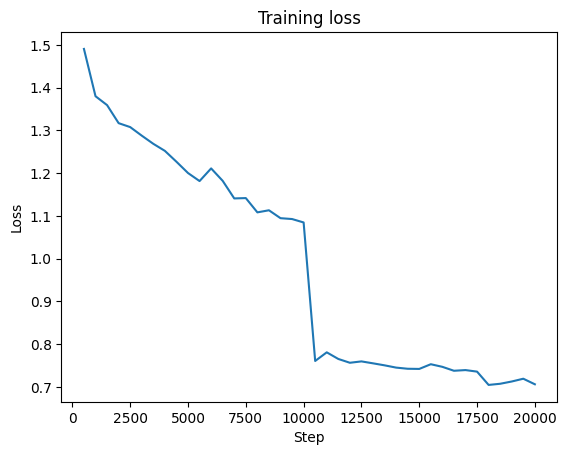

In [10]:
import matplotlib.pyplot as plt

x = [obj['step'] for obj in train_history]
y = [obj['loss'] for obj in train_history]

plt.title('Training loss')
plt.plot(x,y)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.savefig("t5-logging/t5_training_loss.png")
plt.show()

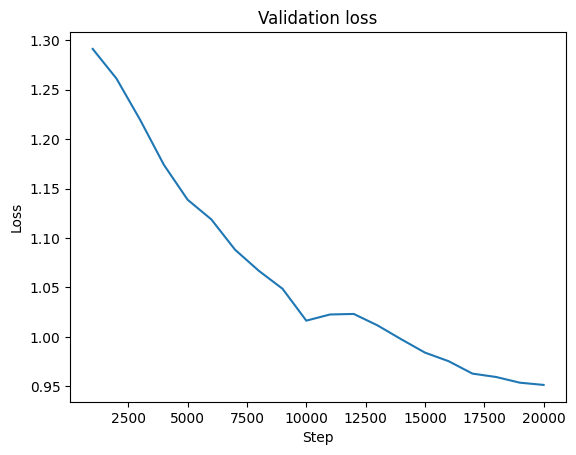

In [11]:
import matplotlib.pyplot as plt

x = [obj['step'] for obj in eval_history]
y = [obj['eval_loss'] for obj in eval_history]

plt.title('Validation loss')
plt.plot(x,y)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.savefig("t5-logging/t5_validation_loss.png")
plt.show()
